In [196]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

class Game:
    def __init__ (self, n_patients, n_enf):
        self.n_patients=n_patients
        self.n_enf=n_enf
        self.reset_patients(self.n_patients)
        
    def reset_patients (self, n_patients, p_short_stay=0.5):
        ''' Define cuando los pacientes que llegan al hospital y su tiempo de estancia
        Parametros:
            n_patients: numero de pacientes que llegan al hospital
            p_short_stay (default 0.5): probabilidad de que un paciente sea de corta estancia
        '''
        stay_length=lambda kind: 1 if kind=='short' else 2
        self.patient_kind_stay=np.random.choice(['short','long'],p=[p_short_stay,1-p_short_stay],size=n_patients)
        self.patient_entry = np.random.exponential(scale=4,size=(self.n_patients)).astype(int)
        self.patient_entry.sort()
        self.patient_entry+=np.arange(self.n_patients)-self.patient_entry.min()
        self.patient_exit = self.patient_entry + np.vectorize(stay_length)(self.patient_kind_stay)
    
    def run_exp (self, funcion_acciones):
        assignment=np.zeros((self.n_enf,self.n_patients)) 
        u_time, u_penal = np.zeros((self.patient_exit.max(), self.n_enf)), np.zeros((self.patient_exit.max(), self.n_enf))

        for patient in self.patient_entry.argsort():
            tick=self.patient_entry[patient]
            
            # ¿a qué enfermera se le asigna?
            enf, voluntario=funcion_acciones(assignment=assignment,n_enf=self.n_enf,patient=patient)

            # si ninguna enfermera acepta, se asigna a la que menos pacientes tenga
            if not voluntario: u_penal[tick:self.patient_exit[patient],enf]=1

            # actualizar la ocupacion/pago de las enfermeras
            assignment[enf,patient]=self.patient_exit[patient]
            u_time[tick:self.patient_exit[patient],enf]+=1
            assignment[assignment<=tick]=0 # eliminar a los pacientes que ya se han ido
        
        return self.fix_utilities(u_time,u_penal)

    def fix_utilities(self,u_time,u_penal):
        return u_time * [0.1,0.2,0.3] + u_penal * [0.3,0.2,0.1]
    
    def plot_pagos(self,u):
        fig=plt.figure(figsize=(10,3))
        plt.plot(u, marker='o',markersize=3,linestyle=':',drawstyle = 'steps-post')
        fig.legend(['U_%i'%i for i in range(u.shape[0])],bbox_to_anchor=(1,1.04),ncol=u.shape[0])
        plt.title('funcion de pagos de los agentes')
        plt.xlabel('tiempo'); plt.ylabel('utilidad')
        fig.tight_layout()
        return fig
    
    def plot_pacientes(self):
        fig, ax=plt.subplots(figsize=(10,3))
        for  y, x1, x2 in zip(range(4), self.patient_entry, self.patient_exit):
            plt.plot([x1,x2], [y+1, y+1], '|-', label='paciente %i'%(y+1),linewidth=3)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title('Agenda de pacientes')
        plt.xlabel('tiempo'); plt.ylabel('paciente')
        fig.tight_layout()
        return fig

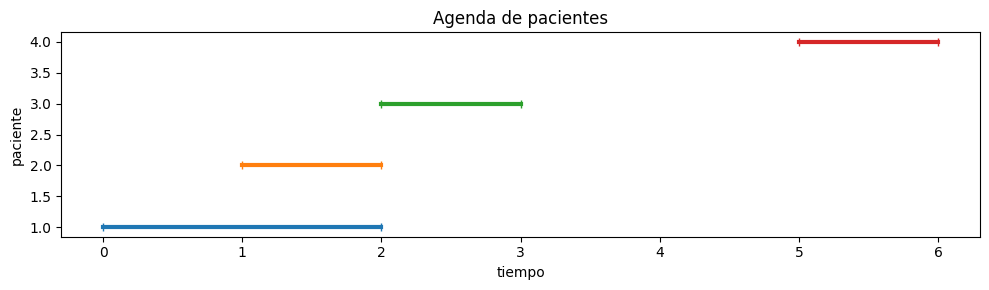

In [197]:
np.random.seed(15)
n_patients=4; n_enf=3
game = Game(n_patients, n_enf)
_=game.plot_pacientes()

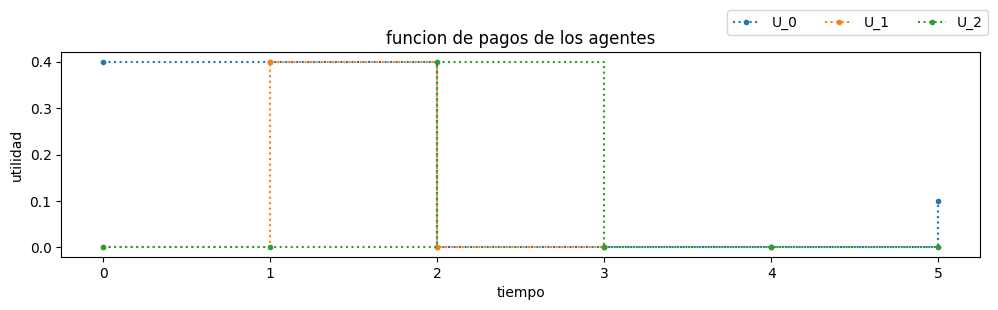

In [198]:
def mixed_strategies (assignment, n_enf,**kwargs):
    try:
        enf=np.random.choice(['acepta','rechaza'],p=[0.1,0.9],size=n_enf).tolist().index('acepta')
        return enf, True
    except ValueError:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False

u_0 = game.run_exp(funcion_acciones=mixed_strategies)
_ = game.plot_pagos(u_0)

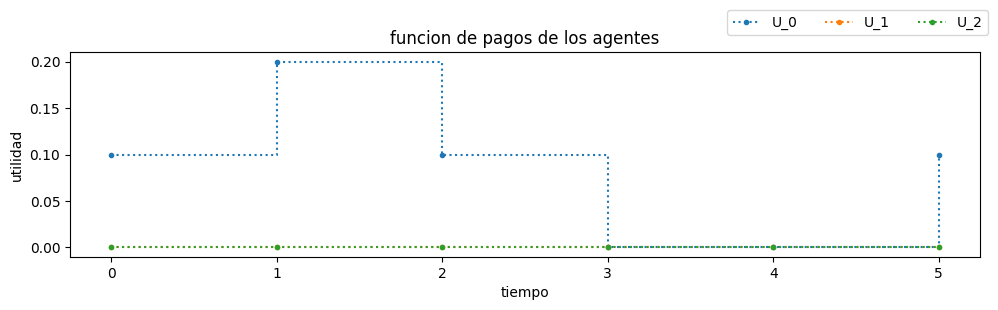

In [199]:
def always_i (enf, **kwargs):
    return enf, True

enf=0
u_0 = game.run_exp(funcion_acciones=partial(always_i, enf))
_ = game.plot_pagos(u_0)

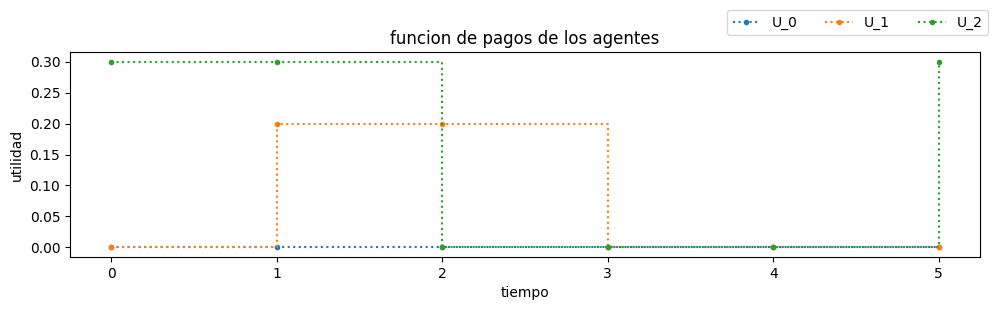

In [200]:
def never_i (enf, n_enf, **kwargs):
    return np.random.choice(list(range(1, enf)) + list(range(enf+1, n_enf))), True

enf=0
u_0 = game.run_exp(funcion_acciones=partial(never_i, enf))
_ = game.plot_pagos(u_0)

Que enfermero tomo cada paciente entrante? [-1 -1 -1 -1]


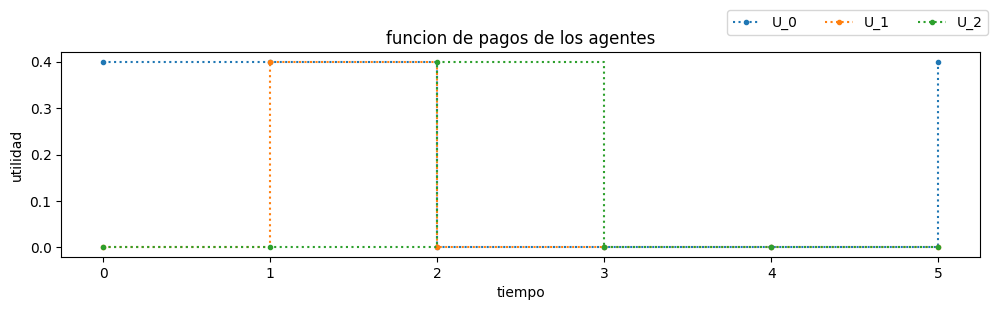

In [201]:
from itertools import product
pure_strategies = np.array(list(product(range(-1,n_enf),repeat=n_patients)))
estrategy_i=0
print('Que enfermero tomo cada paciente entrante?', pure_strategies[estrategy_i])

def pure_strategy (patient, pure_strategy, assignment, **kwargs):
    enf=pure_strategy[patient]
    if enf==-1:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False
    else:
        return enf, True

u_0 = game.run_exp(funcion_acciones=partial(pure_strategy, pure_strategy=pure_strategies[estrategy_i]))
_ = game.plot_pagos(u_0)

In [206]:
import pandas as pd

resultados=pd.DataFrame(pure_strategies, columns=pd.MultiIndex.from_product([['estrategia'],['P%i'%i for i in range(n_patients)]]))
resultados[pd.MultiIndex.from_product([['utilidad'],['U%i'%i for i in range(n_enf)]])]=0

def exp_per_est(x): 
    u_0=game.run_exp(funcion_acciones=partial(pure_strategy, pure_strategy=x.values))
    x['utilidad']=u_0.sum(axis=0)
    x[('utilidad','Total')]=x['utilidad'].sum()
    return x

resultados=resultados.apply(exp_per_est,axis=1)
resultados


estrategia                utilidad                
            P0   P1   P2   P3       U0   U1   U2 Total
0         -1.0 -1.0 -1.0 -1.0      1.2  0.4  0.4   2.0
1         -1.0 -1.0 -1.0  0.0      0.9  0.4  0.4   1.7
2         -1.0 -1.0 -1.0  1.0      0.8  0.6  0.4   1.8
3         -1.0 -1.0 -1.0  2.0      0.8  0.4  0.7   1.9
4         -1.0 -1.0  0.0 -1.0      0.9  0.8  0.0   1.7
..         ...  ...  ...  ...      ...  ...  ...   ...
251        2.0  2.0  1.0  2.0      0.0  0.2  1.2   1.4
252        2.0  2.0  2.0 -1.0      0.4  0.0  1.2   1.6
253        2.0  2.0  2.0  0.0      0.1  0.0  1.2   1.3
254        2.0  2.0  2.0  1.0      0.0  0.2  1.2   1.4
255        2.0  2.0  2.0  2.0      0.0  0.0  1.5   1.5

[256 rows x 8 columns]